In [1]:
from pyforest import *

In [2]:
df = pd.read_csv('dummies.csv')

<IPython.core.display.Javascript object>

In [3]:
pd.options.display.max_columns = None
df

<IPython.core.display.Javascript object>

,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,readmitted,total_patient_interaction,numchange,race_AfricanAmerican,race_Caucasian,race_Other,age_0-40,age_41-70,age_71-100,admission_type_id_elective,admission_type_id_emergency,admission_type_id_na,discharge_disposition_id_discharged_home,discharge_disposition_id_inpatient,discharge_disposition_id_left_AMA,discharge_disposition_id_na,discharge_disposition_id_transferred,discharge_disposition_id_under_treatment,"diag_1_Complications of Pregnancy, Childbirth and the Puerperium",diag_1_Congenital Anomalies,diag_1_Diseases of Blood and Blood Forming Organs,diag_1_Diseases of Nervous System and Sense Organs,diag_1_Diseases of circulatory system,diag_1_Diseases of respiratory system,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_1_Infectious and Parasitic Disease,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_1_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions","diag_2_Complications of Pregnancy, Childbirth and the Puerperium",diag_2_Congenital Anomalies,diag_2_Diseases of Blood and Blood Forming Organs,diag_2_Diseases of Nervous System and Sense Organs,diag_2_Diseases of circulatory system,diag_2_Diseases of respiratory system,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_2_Infectious and Parasitic Disease,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_2_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions","diag_3_Complications of Pregnancy, Childbirth and the Puerperium",diag_3_Congenital Anomalies,diag_3_Diseases of Blood and Blood Forming Organs,diag_3_Diseases of Nervous System and Sense Organs,diag_3_Diseases of circulatory system,diag_3_Diseases of respiratory system,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Skin and Subcutaneous Tissue,"diag_3_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_3_Infectious and Parasitic Disease,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Neoplasms,diag_3_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_3_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_3_Symptoms, Signs and Ill-defined Conditions",max_glu_serum_abnormal,max_glu_serum_normal,max_glu_serum_not_tested,A1Cresult_abnormal,A1Cresult_normal,A1Cresult_not tested,change_No,change_Yes,diabetesMed_No,diabetesMed_Yes
0,1,41,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
1,3,59,18,9,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
2,2,11,13,6,0,3,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1
3,2,44,16,7,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [4]:
import io
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [5]:
df.mean()

time_in_hospital         4.273364
num_lab_procedures      42.875088
num_medications         15.666424
number_diagnoses         7.224428
readmitted               0.089811
                          ...    
A1Cresult_not tested     0.816447
change_No                0.549915
change_Yes               0.450085
diabetesMed_No           0.238406
diabetesMed_Yes          0.761594
Length: 86, dtype: float64

In [6]:
X = df.drop('readmitted',axis=1)
y = df['readmitted']

In [7]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
pd.options.display.max_rows = 120
X.corr()

<IPython.core.display.Javascript object>

,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,total_patient_interaction,numchange,race_AfricanAmerican,race_Caucasian,race_Other,age_0-40,age_41-70,age_71-100,admission_type_id_elective,admission_type_id_emergency,admission_type_id_na,discharge_disposition_id_discharged_home,discharge_disposition_id_inpatient,discharge_disposition_id_left_AMA,discharge_disposition_id_na,discharge_disposition_id_transferred,discharge_disposition_id_under_treatment,"diag_1_Complications of Pregnancy, Childbirth and the Puerperium",diag_1_Congenital Anomalies,diag_1_Diseases of Blood and Blood Forming Organs,diag_1_Diseases of Nervous System and Sense Organs,diag_1_Diseases of circulatory system,diag_1_Diseases of respiratory system,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_1_Infectious and Parasitic Disease,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_1_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions","diag_2_Complications of Pregnancy, Childbirth and the Puerperium",diag_2_Congenital Anomalies,diag_2_Diseases of Blood and Blood Forming Organs,diag_2_Diseases of Nervous System and Sense Organs,diag_2_Diseases of circulatory system,diag_2_Diseases of respiratory system,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_2_Infectious and Parasitic Disease,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_2_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions","diag_3_Complications of Pregnancy, Childbirth and the Puerperium",diag_3_Congenital Anomalies,diag_3_Diseases of Blood and Blood Forming Organs,diag_3_Diseases of Nervous System and Sense Organs,diag_3_Diseases of circulatory system,diag_3_Diseases of respiratory system,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Skin and Subcutaneous Tissue,"diag_3_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_3_Infectious and Parasitic Disease,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Neoplasms,diag_3_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_3_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_3_Symptoms, Signs and Ill-defined Conditions",max_glu_serum_abnormal,max_glu_serum_normal,max_glu_serum_not_tested,A1Cresult_abnormal,A1Cresult_normal,A1Cresult_not tested,change_No,change_Yes,diabetesMed_No,diabetesMed_Yes
time_in_hospital,1.000000,0.332178,0.468059,0.233878,0.011825,0.167634,0.009957,0.001337,-0.021211,-0.072184,-0.068513,0.104742,-0.031014,0.033800,-0.010412,-0.214373,0.017827,-0.039540,0.041788,0.217958,-0.001409,-0.035195,0.001568,-0.010100,0.005375,-0.021912,0.077299,0.003176,-0.017578,-0.037917,0.031350,-0.025423,0.062701,0.020911,0.075929,0.058284,0.000936,0.115226,-0.163537,-0.024181,-0.006465,0.005449,0.001749,-0.027046,0.076767,0.024915,0.031123,0.005096,0.082806,-0.108428,0.036033,0.042991,0.002020,0.037298,-0.023893,-0.022381,-0.020403,-0.020614,0.000865,0.025945,-0.003508,-0.024921,0.081512,0.014611,0.056700,0.010063,0.087693,-0.098499,0.034499,0.059390,-0.008368,0.034899,-0.019999

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

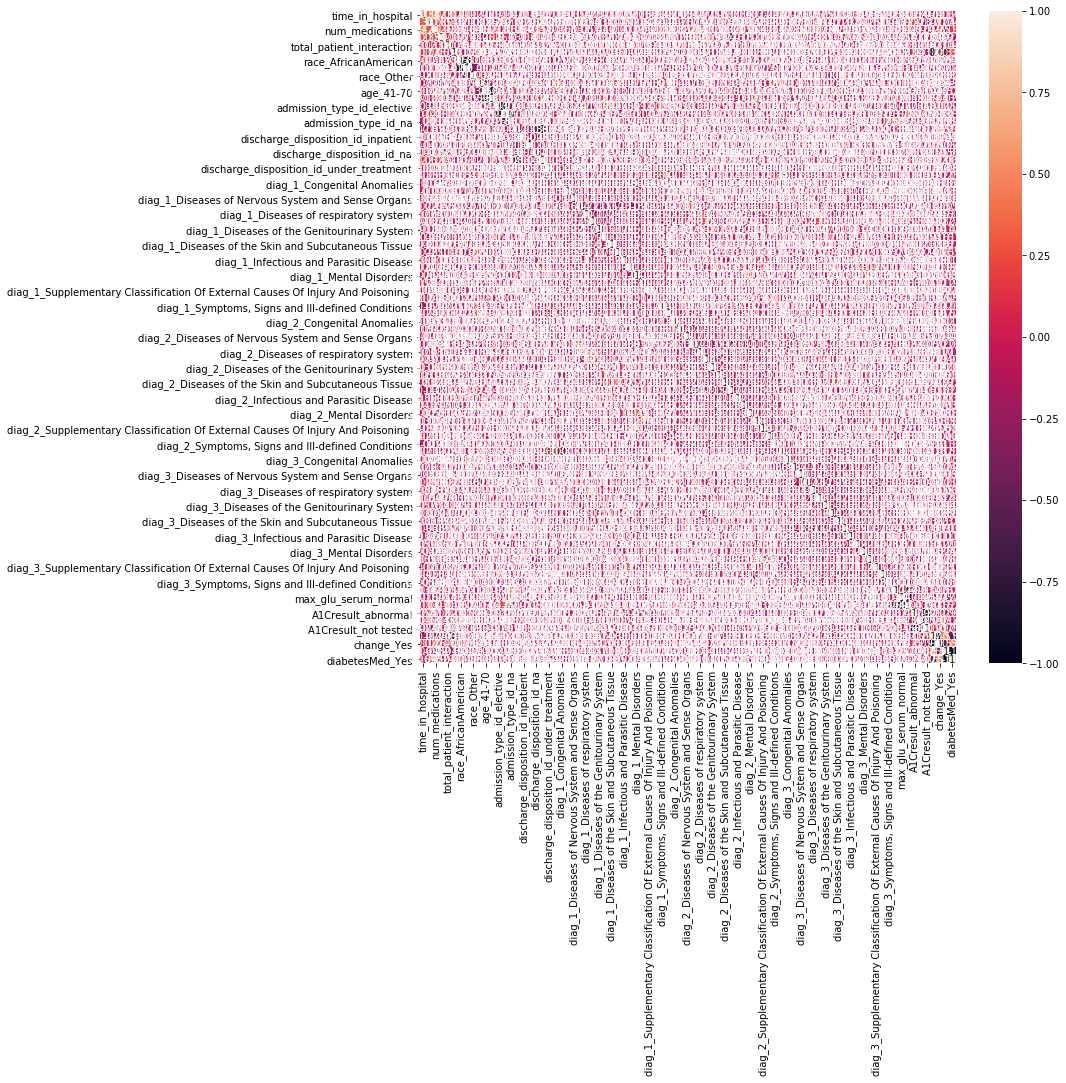

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),annot=True)
plt.show()

In [13]:
#covariance matrix
reduce_mem_usage(X)
cov_mat = np.array(round(X.cov(),2))
cov_mat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Memory usage of dataframe is 5.74 MB --> 5.74 MB (Decreased by 0.0%)


<IPython.core.display.Javascript object>

array([[ 8.6100e+00,  1.9390e+01,  1.1380e+01, ...,  1.6000e-01,
        -9.0000e-02,  9.0000e-02],
       [ 1.9390e+01,  3.9576e+02,  4.2710e+01, ...,  7.6000e-01,
        -3.8000e-01,  3.8000e-01],
       [ 1.1380e+01,  4.2710e+01,  6.8690e+01, ...,  1.0100e+00,
        -6.6000e-01,  6.6000e-01],
       ...,
       [ 1.6000e-01,  7.6000e-01,  1.0100e+00, ...,  2.5000e-01,
        -1.1000e-01,  1.1000e-01],
       [-9.0000e-02, -3.8000e-01, -6.6000e-01, ..., -1.1000e-01,
         1.8000e-01, -1.8000e-01],
       [ 9.0000e-02,  3.8000e-01,  6.6000e-01, ...,  1.1000e-01,
        -1.8000e-01,  1.8000e-01]])

In [14]:
round(pd.DataFrame(cov_mat),4)

<IPython.core.display.Javascript object>

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,8.61,19.39,11.38,1.37,0.05,0.23,0.01,0.00,-0.01,-0.05,-0.10,0.15,-0.04,0.05,-0.01,-0.27,0.0,-0.01,0.03,0.25,-0.0,-0.01,0.0,-0.00,0.00,-0.03,0.07,0.00,-0.01,-0.03,0.01,-0.02,0.03,0.02,0.03,0.03,0.0,0.04,-0.13,-0.01,-0.00,0.00,0.00,-0.04,0.07,0.01,0.02,0.00,0.04,-0.13,0.01,0.02,0.00,0.02,-0.01,-0.01,-0.01,-0.00,0.0,0.01,-0.00,-0.03,0.06,0.01,0.04,0.00,0.04,-0.13,0.01,0.02,-0.00,0.01,-0.01,-0.02,-0.00,0.02,-0.01,-0.01,0.05,0.03,-0.08,-0.16,0.16,-0.09,0.09
1,19.39,395.76,42.71,6.13,0.94,1.22,0.16,-0.15,-0.01,-0.01,-0.27,0.28,-1.74,1.80,-0.06,-0.47,-0.0,0.02,-0.03,0.49,-0.0,-0.10,-0.0,0.02,0.00,0.27,0.31,0.19,0.14,-0.63,-0.05,0.15,0.22,-0.14,-0.02,-0.15,0.0,-0.10,-0.11,-0.06,-0.01,-0.06,-0.01,-0.04,0.25,0.08,0.31,-0.10,0.01,-0.26,0.08,-0.05,0.02,-0.02,-0.02,-0.10,-0.04,-0.04,-0.0,0.07,-0.00,-0.17,0.23,0.05,0.32,-0.06,0.05,-0.34,0.07,0.03,0.01,0.03,-0.04,-0.21,0.02,-0.21,-0.35,0.56,1.49,0.60,-2.09,-0.76,0.76,-0.38,0.38
2,11.38,42.71,68.69,4.30,0.45,0.89,-0.14,0.22,-0.08,-0.22,0.27,-0.04,0.58,-0.62,0.04,-0.34,0.0,-0.02,0.01,0.35,-0.0,-0.03,0.0,-0.03,-0.03,0.41,0.14,-0.10,-0.06,0.24,-0.02,-0.26,0.02,0.08,-0.09,0.06,0.0,-0.01,-0.32,-0.01,0.00,0.03,-0.02,0.32,0.20,-0.02,0.01,0.02,0.03,-0.46,0.00,0.08,-0.07,0.01,-0.01,-0.02,-0.08,-0.01,0.0,0.04,-0.03,0.19,0.17,-0.01,0.06,0.00,0.04,-0.34,-0.00,0.08,-0.06,0.00,-0.01,-0.06,-0.06,0.00,-0.05,0.05,0.03,0.03,-0.06,-1.01,1.01,-0.66,0.66
3,1.37,6.13,4.30,4.00,0.30,0.06,-0.06,0.08,-0.02,-0.10,-0.06,0.16,-0.05,0.10,-0.04,-0.09,0.0,-0.00,-0.03,0.12,0.0,-0.01,-0.0,0.00,-0.00,0.05,0.03,-0.00,0.01,-0.04,-0.00,-0.07,0.02,0.02,-0.01,-0.01,0.0,0.01,-0.01,-0.00,0.00,0.01,0.00,0.06,0.05,0.01,0.05,-0.00,0.01,-0.21,0.00,0.02,-0.01,0.01,0.00,-0.01,0.01,-0.00,0.0,0.01,0.00,0.06,0.05,0.01,0.05,0.00,0.02,-0.23,0.01,0.02,-0.01,0.01,0.01,-0.02,0.02,-0.01,-0.02,0.03,-0.02,0.01,0.01,-0.05,0.05,-0.02,0.02
4,0.05,0.94,0.45,0.30,2.04,0.02,-0.02,0.02,-0.00,0.00,-0.01,0.01,-0.02,-0.01,0.03,0.00,0.0,0.00,-0.02,0.01,-0.0,0.00,0.0,0.00,0.00,-0.02,0.00,-0.00,0.00,-0.00,0.00,0.01,0.00,0.00,0.00,-0.00,-0.0,0.01,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.01,-0.02,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.0,0.00,0.00,0.00,0.00,-0.00,0.01,0.00,0.00,-0.02,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.01,0.01,-0.01,-0.01,-0.01,0.02,-0.02,0.02,-0.02,0.02
5,0.23,1.22,0.89,0.06,0.02,0.23,0.00,-0.00,0.00,0.01,0.01,-0.01,0.00,-0.00,0.00,-0.00,0.0,0.00,-0.00,0.01,-0.0,0.00,-0.0,-0.00,-0.00,-0.00,0.01,-0.01,-0.00,-0.00,0.00,0.02,0.00,-0.00,-0.00,-0.00,-0.0,-0.00,-0.01,0.00,-0.00,-0.00,0.00,-0.01,0.00,-0.00,0.00,-0.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0,-0.00,0.00,-0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.02,0.00,-0.02,-0.14,0.14,-0.06,0.06
6,0.01,0.16,-0.14,-0.06,-0.02,0.00,0.15,-0.14,-0.01,0.01,0.02,-0.03,-0.01,0.01,-0.01,0.01,-0.0,0.00,0.00,-0.01,-0.0,0.00,0.0,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00,-0.0,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.0,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
7,0.00,-0.15,0.22,0.08,0.02,-0.00,-0.14,0.17,-0.03,-0.01,-0.02,0.03,0.01,-0.01,0.01,-0.01,0.0,-0.00,-0.00,0.01,0.0,-0.00,-0.0,-0.00,-0.00,0.01,0.00,-0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,-0.0,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.01,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.0,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00
8,-0.01,-0.01,-0.08,-0.02,-0.00,0.00,-0.01,-0.03,0.04,0.

In [15]:
X_std = StandardScaler().fit_transform(X)
type(X_std)

numpy.ndarray

In [16]:
X_std

array([[-1.11561381, -0.09425648, -1.76967042, ..., -0.90468944,
         1.78732557, -1.78732557],
       [-0.43398241,  0.81056352,  0.28157246, ...,  1.10535169,
        -0.55949516,  0.55949516],
       [-0.77479811, -1.60228983, -0.32173427, ..., -0.90468944,
        -0.55949516,  0.55949516],
       ...,
       [-0.77479811,  0.15708241,  0.16091111, ..., -0.90468944,
        -0.55949516,  0.55949516],
       [ 0.24764898,  1.66511576,  0.76421784, ...,  1.10535169,
        -0.55949516,  0.55949516],
       [ 0.58846468, -1.50175428, -1.52834773, ..., -0.90468944,
         1.78732557, -1.78732557]])

In [17]:
X_std = pd.DataFrame(X_std)

<IPython.core.display.Javascript object>

In [15]:
pd.options.display.max_columns = None
X_std

<IPython.core.display.Javascript object>

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,-1.115614,-0.094256,-1.769670,-3.110376,-0.392063,-1.262620,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,2.865324,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,1.571348,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,-1.745036,-0.028554,-0.07668,4.529424,-0.490674,-0.005346,-0.495355,-1.492781,2.805608,-0.904689,-1.787326
1,-0.433982,0.810564,0.281572,0.887262,-0.392063,-0.201746,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,2.865324,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,1.571348,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,1.105352,0.559495
2,-0.774798,-1.602290,-0.321734,-0.611852,1.708952,-0.201746,2.131323,-1.854783,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,10.890598,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,-0.636396,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,5.105616,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,-0.904689,0.559495
3,-0.774798,0.056547,0.040250,-0.112148,-0.392063,-0.201746,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,6.365896,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,1.547069,-0.032538,-0.190368,-0.636396,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,1.105352,0.559495
4,-1.115614,0.408421,-0.925041,-1.111557,-0.392063,0.859128,-0.469192,0.539147,-0.216545,-0.262111,1.003536,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,5.154470,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,-0.535591,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,6.536867,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.1903

In [16]:
#covariance matrix
cov_mat = np.cov(X_std,rowvar=False)
cov_mat.round(1)

<IPython.core.display.Javascript object>

array([[ 1. ,  0.3,  0.5, ..., -0. ,  0.1,  0.1],
       [ 0.3,  1. ,  0.3, ..., -0. ,  0.1,  0. ],
       [ 0.5,  0.3,  1. , ...,  0. ,  0.2,  0.2],
       ...,
       [-0. , -0. ,  0. , ...,  1. , -0. , -0. ],
       [ 0.1,  0.1,  0.2, ..., -0. ,  1. ,  0.5],
       [ 0.1,  0. ,  0.2, ..., -0. ,  0.5,  1. ]])

In [17]:
pca = PCA()

In [18]:
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
pc_score = pca.transform(X_std)
pc_score.round(2)

array([[ 3.51,  2.7 ,  0.17, ...,  0.  , -0.  , -0.  ],
       [ 1.6 , -1.32,  0.76, ...,  0.  ,  0.  , -0.  ],
       [ 6.07,  0.03,  0.76, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.55, -0.71, -0.81, ..., -0.  ,  0.  , -0.  ],
       [-0.95, -1.15,  0.06, ..., -0.  ,  0.  , -0.  ],
       [ 0.68,  1.58, -3.2 , ...,  0.  , -0.  ,  0.  ]])

In [20]:
#captured variance by each principal components
pca.explained_variance_.round(2)

array([3.09, 2.93, 2.54, 2.42, 2.35, 2.  , 1.86, 1.82, 1.79, 1.62, 1.51,
       1.48, 1.45, 1.42, 1.38, 1.34, 1.31, 1.27, 1.19, 1.17, 1.14, 1.13,
       1.12, 1.11, 1.08, 1.07, 1.07, 1.06, 1.04, 1.03, 1.03, 1.03, 1.02,
       1.01, 1.01, 1.01, 1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.99, 0.98,
       0.97, 0.96, 0.96, 0.95, 0.93, 0.93, 0.91, 0.9 , 0.89, 0.89, 0.88,
       0.86, 0.84, 0.82, 0.78, 0.77, 0.76, 0.75, 0.74, 0.72, 0.7 , 0.68,
       0.65, 0.6 , 0.55, 0.51, 0.49, 0.39, 0.2 , 0.17, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [21]:
cov_mat = np.cov(pc_score,rowvar=False)
cov_mat.round(1)

<IPython.core.display.Javascript object>

array([[ 3.1, -0. ,  0. , ..., -0. , -0. , -0. ],
       [-0. ,  2.9,  0. , ...,  0. ,  0. , -0. ],
       [ 0. ,  0. ,  2.5, ...,  0. ,  0. ,  0. ],
       ...,
       [-0. ,  0. ,  0. , ...,  0. , -0. , -0. ],
       [-0. ,  0. ,  0. , ..., -0. ,  0. ,  0. ],
       [-0. , -0. ,  0. , ..., -0. ,  0. ,  0. ]])

In [22]:
#percentage of variance
exp_var = pca.explained_variance_ratio_
exp_var = np.round(exp_var*100, decimals=1)
exp_var

<IPython.core.display.Javascript object>

array([3.7, 3.5, 3.1, 2.9, 2.8, 2.4, 2.2, 2.2, 2.2, 2. , 1.8, 1.8, 1.7,
       1.7, 1.7, 1.6, 1.6, 1.5, 1.4, 1.4, 1.4, 1.4, 1.4, 1.3, 1.3, 1.3,
       1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1,
       1.1, 1.1, 1.1, 1. , 1. , 1. , 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8,
       0.8, 0.8, 0.7, 0.7, 0.6, 0.6, 0.5, 0.2, 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. ])

In [23]:
np.cumsum(exp_var)

<IPython.core.display.Javascript object>

array([ 3.7,  7.2, 10.3, 13.2, 16. , 18.4, 20.6, 22.8, 25. , 27. , 28.8,
       30.6, 32.3, 34. , 35.7, 37.3, 38.9, 40.4, 41.8, 43.2, 44.6, 46. ,
       47.4, 48.7, 50. , 51.3, 52.6, 53.9, 55.2, 56.4, 57.6, 58.8, 60. ,
       61.2, 62.4, 63.6, 64.8, 66. , 67.2, 68.4, 69.6, 70.8, 72. , 73.2,
       74.4, 75.6, 76.8, 77.9, 79. , 80.1, 81.2, 82.3, 83.4, 84.5, 85.6,
       86.6, 87.6, 88.6, 89.5, 90.4, 91.3, 92.2, 93.1, 94. , 94.8, 95.6,
       96.4, 97.1, 97.8, 98.4, 99. , 99.5, 99.7, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9])

In [24]:
a = np.cumsum(exp_var)

<IPython.core.display.Javascript object>

In [32]:
a = list(np.cumsum(exp_var))
a[59]

<IPython.core.display.Javascript object>

90.39999999999999

In [33]:
labels = ['PC' + str(x) for x in range(1,len(exp_var)+1)]

In [34]:
labels

['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC20',
 'PC21',
 'PC22',
 'PC23',
 'PC24',
 'PC25',
 'PC26',
 'PC27',
 'PC28',
 'PC29',
 'PC30',
 'PC31',
 'PC32',
 'PC33',
 'PC34',
 'PC35',
 'PC36',
 'PC37',
 'PC38',
 'PC39',
 'PC40',
 'PC41',
 'PC42',
 'PC43',
 'PC44',
 'PC45',
 'PC46',
 'PC47',
 'PC48',
 'PC49',
 'PC50',
 'PC51',
 'PC52',
 'PC53',
 'PC54',
 'PC55',
 'PC56',
 'PC57',
 'PC58',
 'PC59',
 'PC60',
 'PC61',
 'PC62',
 'PC63',
 'PC64',
 'PC65',
 'PC66',
 'PC67',
 'PC68',
 'PC69',
 'PC70',
 'PC71',
 'PC72',
 'PC73',
 'PC74',
 'PC75',
 'PC76',
 'PC77',
 'PC78',
 'PC79',
 'PC80',
 'PC81',
 'PC82',
 'PC83']

In [35]:
pcdf = pd.DataFrame(pc_score, columns = labels)
#pc score are the values which we get after multiplying loading with X_std

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

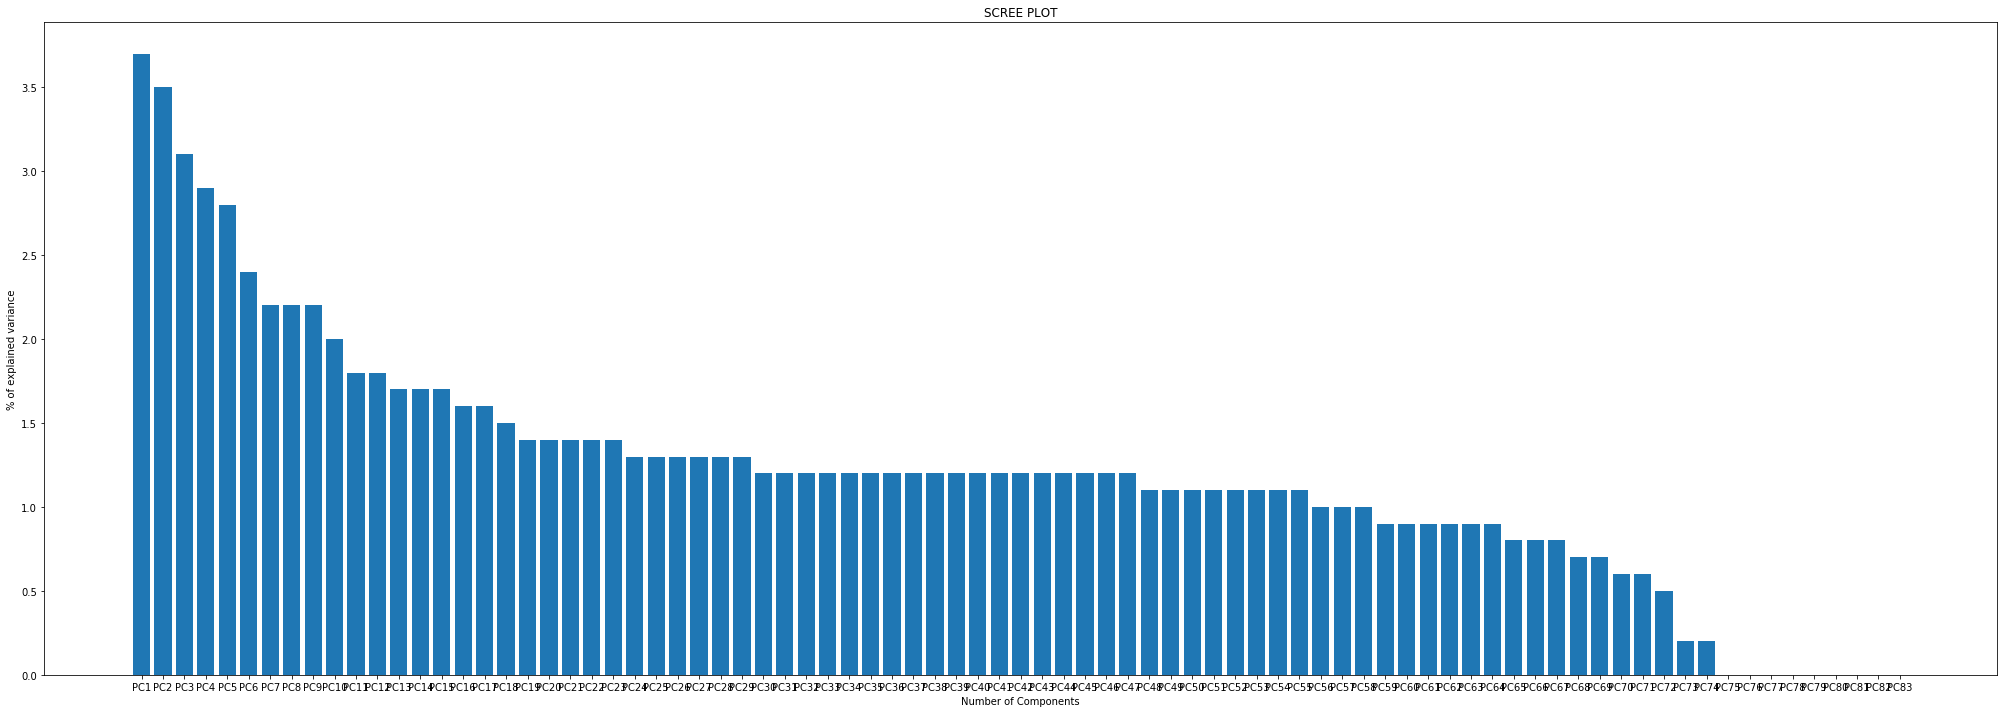

In [36]:
plt.figure(figsize=(35,12))
plt.bar(x = labels, height = exp_var)
plt.xlabel("Number of Components")
plt.ylabel("% of explained variance")
plt.title("SCREE PLOT")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

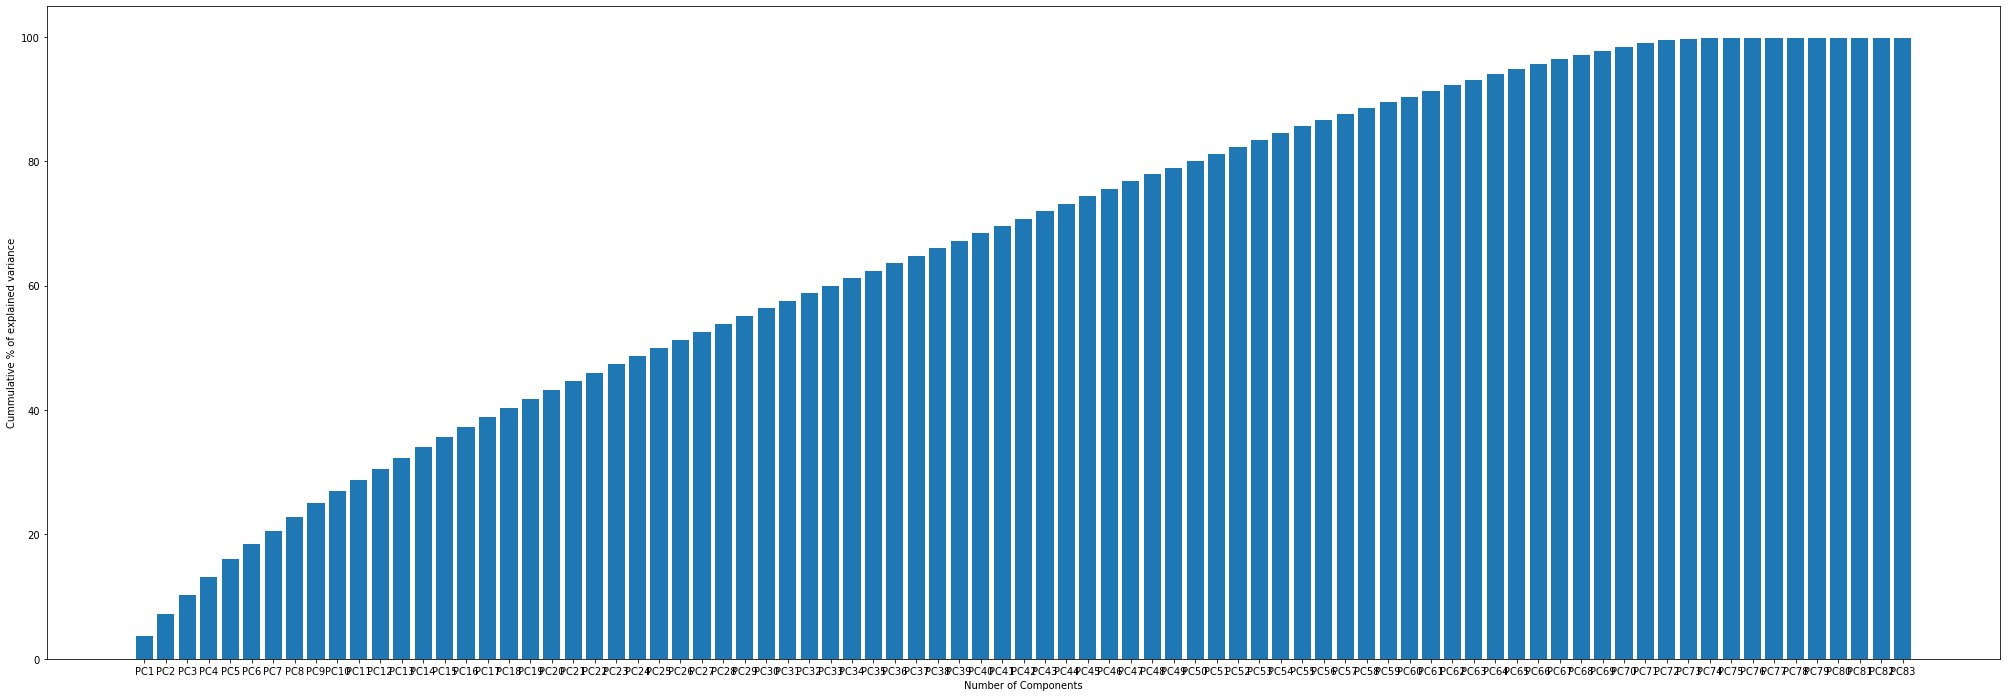

In [37]:
plt.figure(figsize=(35,12))
plt.bar(x = labels, height = a)
plt.xlabel("Number of Components")
plt.ylabel("Cummulative % of explained variance")
plt.show()

In [39]:
X = pcdf.iloc[:,0:59]
Y = pcdf['readmitted']

In [40]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['readmitted'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['readmitted']==0]))
print("Number of subscription",len(os_data_y[os_data_y['readmitted']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==1])/len(os_data_X))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

length of oversampled data is  89148
Number of no subscription in oversampled data 44574
Number of subscription 44574
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [42]:
X_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59
41255,-1.295202,0.907399,2.602238,0.178624,-0.610463,-0.485909,-0.970460,-0.081202,0.062980,-0.041612,2.103932,-0.495113,0.093543,0.720360,1.888937,-2.307633,0.516863,-0.154813,-1.446125,-0.093239,0.011587,1.134583,-0.078163,-2.384589,0.715532,-0.536948,-0.073626,0.051710,0.164651,1.496744,1.916562,-0.301940,0.356094,-0.603428,0.683866,-0.268660,0.349495,-0.520499,0.273494,1.043424,-1.208604,0.155196,-0.714290,-0.033132,0.001380,-0.428786,-0.845038,0.262917,-0.027175,0.088098,-0.474677,0.004435,0.677977,-2.358471,-0.270946,-2.013700,2.152824,-1.501893,1.356984
10397,1.598051,0.511066,-1.727354,-0.957570,-0.821850,1.069938,-0.289506,0.454762,0.324143,0.941679,0.270856,0.844043,0.150442,1.499245,-0.833578,1.415011,-0.554999,0.669562,-0.351030,-0.119071,-1.128924,0.148620,-0.204406,1.114555,0.061675,0.575451,-0.237611,-0.373475,0.362090,-0.410951,-0.457439,-0.108011,0.468289,0.101144,0.530524,0.083461,0.469972,-0.246894,-0.037858,-0.066810,-0.312577,0.882116,-0.258092,0.338175,0.330173,0.138479,0.864154,0.174831,-0.881071,-0.429576,0.324374,-0.178810,0.027082,-0.223533,-0.197277,0.088735,-0.406485,-0.473577,-0.067662
9817,-0.716932,6.461158,1.476411,-1.885285,4.031440,1.198363,0.234711,-0.565925,0.520412,-0.384467,-0.748642,1.755773,0.737311,1.519543,0.357932,0.832712,-0.125882,-0.247580,-0.555516,0.170205,-0.369605,0.074971,-0.139242,0.516496,-0.431642,-0.130085,-0.456109,-0.765765,0.616424,0.699181,-0.153030,-1.297597,0.426327,2.736451,0.754886,1.699992,0.615426,-0.046727,0.785182,-1.003226,0.609470,-1.008302,-1.701601,-0.000387,0.833112,0.733005,1.051501,0.982288,0.163917,0.345333,0.292206,0.040981,0.291613,-0.245353,-0.229449,0.470366,0.376210,-0.002891,-0.364603
68220,-0.603788,0.672175,-1.488559,0.495499,0.496473,-0.763125,-0.869338,1.189434,-0.102089,0.393593,-0.947252,3.861948,1.191017,-1.613496,-0.593817,0.507061,0.920661,1.751220,-2.349418,2.641652,1.996884,0.678076,-1.384329,-0.948630,1.816640,-0.561818,-0.572021,0.543364,-0.616537,2.441256,1.823239,-0.199241,-0.278526,-0.717271,-0.857865,-0.522180,-0.340889,-1.905634,-0.334419,0.996586,-0.609564,1.506870,0.503342,-1.124593,0.230948,1.710180,-1.176404,0.599979,-0.773204,0.082650,1.114195,-1.602126,-0.686747,-0.085198,-0.177292,-0.426335,2.127083,1.218542,1.218955
46184,-3.129240,-1.241818,2.411398,1.745996,-1.628397,-0.720093,5.388738,-0.302797,0.490679,-0.069728,0.812676,0.047059,-1.001272,-0.747776,-0.164416,-0.101587,-1.809239,0.526568,0.062132,-0.699246,-1.453818,0.523040,-1.469428,-0.436512,-0.017852,-0.474287,-1.330947,0.050622,-0.887290,-0.902829,-0.928655,0.030450,-0.392529,0.092355,-0.726151,0.360637,-1.367899,-0.020081,-0.155671,-0.231124,1.194073,0.164385,-0.026185,-0.929162,0.074816,0.950691,0.848568,0.721176,1.082995,0.430130,-0.945575,0.166285,0.042894,0.060508,-0.767293,0.476510,0.619644,-0.867414,-0.587165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,3.331766,-3.535006,1.638739,-2.151289,1.663862,0.187925,0.032747,-1.655793,1.418093,-1.441067,-0.975715,-0.746139,-0.206699,-0.498702,-0.478551,0.574636,0.318886,0.704402,-0.128148,-0.869762,-0.933428,0.139867,0.002419,0.370199,-0.527676,-0.027233,-0.306132,-0.677769,0.274080,0.277836,-0.197421,-0.424474,0.232586,0.364650,0.322161,-0.149525,0.088500,0.027137,0.014832,-0.064165,0.349824,-0.500676,0.261155,0.092010,0.548022,0.142352,-0.150983,0.066577,0.151013,-0.222161,0.667034,0.261030,0.383104,-0.044778,-0.157972,0.495962,-0.127473,-0.057242,-0.008019
45891,1.302683,-0.891401,-1.019495,-0.908746,-1.413156,1.590740,2.723295,-1.4

### Decision Tree (Base)

In [43]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10,random_state=0)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
dtree_pred = dtree.predict(X_test)
cm = confusion_matrix(y_test,dtree_pred)
print(cm)

[[17554  1557]
 [ 1693   187]]


In [46]:
cr = classification_report(y_test,dtree_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     19111
           1       0.11      0.10      0.10      1880

    accuracy                           0.85     20991
   macro avg       0.51      0.51      0.51     20991
weighted avg       0.84      0.85      0.84     20991



In [47]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.85
Precision is 0.11
Recall is 0.10


### Random Forest (Base)

In [48]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10,random_state=0)
rm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [49]:
rm_prd = rm.predict(X_test)
cm = confusion_matrix(y_test,rm_prd)
print(cm)

[[19078    33]
 [ 1869    11]]


In [50]:
cr = classification_report(y_test,rm_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19111
           1       0.25      0.01      0.01      1880

    accuracy                           0.91     20991
   macro avg       0.58      0.50      0.48     20991
weighted avg       0.85      0.91      0.87     20991



In [51]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.91
Precision is 0.25
Recall is 0.01


In [52]:
from sklearn.preprocessing import scale as scale
scaled_df = scale(df)
scaled_df

array([[-1.11561381, -0.09425648, -1.76967042, ...,  2.8056076 ,
        -0.90468944, -1.78732557],
       [-0.43398241,  0.81056352,  0.28157246, ..., -0.35642903,
         1.10535169,  0.55949516],
       [-0.77479811, -1.60228983, -0.32173427, ..., -0.35642903,
        -0.90468944,  0.55949516],
       ...,
       [-0.77479811,  0.15708241,  0.16091111, ..., -0.35642903,
        -0.90468944,  0.55949516],
       [ 0.24764898,  1.66511576,  0.76421784, ..., -0.35642903,
         1.10535169,  0.55949516],
       [ 0.58846468, -1.50175428, -1.52834773, ..., -0.35642903,
        -0.90468944, -1.78732557]])

In [53]:
scaled_df = pd.DataFrame(scaled_df)

<IPython.core.display.Javascript object>

In [54]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,-1.115614,-0.094256,-1.769670,-3.110376,-0.314123,-0.392063,-1.262620,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,2.865324,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,1.571348,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,-1.745036,-0.028554,-0.07668,4.529424,-0.490674,-0.005346,-0.495355,-1.492781,2.805608,-0.904689,-1.787326
1,-0.433982,0.810564,0.281572,0.887262,-0.314123,-0.392063,-0.201746,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,2.865324,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,1.571348,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,1.105352,0.559495
2,-0.774798,-1.602290,-0.321734,-0.611852,-0.314123,1.708952,-0.201746,2.131323,-1.854783,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,10.890598,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,-0.646383,-0.032538,-0.190368,-0.636396,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,5.105616,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,-0.904689,0.559495
3,-0.774798,0.056547,0.040250,-0.112148,-0.314123,-0.392063,-0.201746,-0.469192,0.539147,-0.216545,3.815178,-0.996476,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,6.365896,-0.268071,-0.150266,-0.248226,-0.194006,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,1.867098,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,-0.152978,-0.113829,-0.071107,-0.318551,-0.181314,-0.133046,-0.15894,1.547069,-0.032538,-0.190368,-0.636396,-0.116,-0.239209,-0.214985,-0.133768,-0.143305,-0.177794,-0.141214,-0.128983,-0.134099,-0.062471,-0.254174,-0.14776,-0.195863,-0.155166,-0.157754,0.224034,-0.386703,-0.237669,0.474151,0.573054,-0.028554,-0.07668,-0.220779,-0.490674,-0.005346,-0.495355,0.669891,-0.356429,1.105352,0.559495
4,-1.115614,0.408421,-0.925041,-1.111557,-0.314123,-0.392063,0.859128,-0.469192,0.539147,-0.216545,-0.262111,1.003536,-0.881880,-0.096985,-0.662132,-0.024214,-0.315247,-0.349001,-0.003781,-0.226521,-0.29214,-0.157087,-0.268071,-0.150266,-0.248226,5.154470,-0.111422,-0.091822,-0.31866,-0.161567,-0.115238,-0.174821,-0.672287,-0.034462,-0.200575,-0.535591,-0.090547,-0.278699,-0.217736,-0.134320,-0.163466,-0.165072,-0.137322,6.536867,-0.113829,-0.071107,-0.318551,-0.

## K-Means Clustering

In [55]:
df

,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,readmitted,total_patient_interaction,numchange,race_AfricanAmerican,race_Caucasian,race_Other,age_0-40,age_41-70,age_71-100,diag_1_Blood,diag_1_Circulatory,diag_1_CongenitalAnomalies,diag_1_Digestive,"diag_1_Endocrine,Nutritional,Metabolic&Immunity",diag_1_ExternalCausesInjury&Poisoning,diag_1_Genitourinary,diag_1_Ill-definedConditions,diag_1_Infectious&Parasitic,diag_1_Injury&Poisoning,diag_1_Mental,diag_1_Musculoskeletal,diag_1_Neoplasms,diag_1_Nervous,diag_1_Pregnancy,diag_1_Respiratory,diag_1_Skin,diag_1_SupplementaryFactors,diag_2_Blood,diag_2_Circulatory,diag_2_CongenitalAnomalies,diag_2_Digestive,"diag_2_Endocrine,Nutritional,Metabolic&Immunity",diag_2_ExternalCausesInjury&Poisoning,diag_2_Genitourinary,diag_2_Ill-definedConditions,diag_2_Infectious&Parasitic,diag_2_Injury&Poisoning,diag_2_Mental,diag_2_Musculoskeletal,diag_2_Neoplasms,diag_2_Nervous,diag_2_Pregnancy,diag_2_Respiratory,diag_2_Skin,diag_2_SupplementaryFactors,diag_3_Blood,diag_3_Circulatory,diag_3_CongenitalAnomalies,diag_3_Digestive,"diag_3_Endocrine,Nutritional,Metabolic&Immunity",diag_3_ExternalCausesInjury&Poisoning,diag_3_Genitourinary,diag_3_Ill-definedConditions,diag_3_Infectious&Parasitic,diag_3_Injury&Poisoning,diag_3_Mental,diag_3_Musculoskeletal,diag_3_Neoplasms,diag_3_Nervous,diag_3_Pregnancy,diag_3_Respiratory,diag_3_Skin,diag_3_SupplementaryFactors,max_glu_serum_abnormal,max_glu_serum_normal,max_glu_serum_not_tested,A1Cresult_abnormal,A1Cresult_normal,A1Cresult_not tested,discharge_disposition_id_discharged_home,discharge_disposition_id_inpatient,discharge_disposition_id_left_AMA,discharge_disposition_id_na,discharge_disposition_id_transferred,discharge_disposition_id_under_treatment,admission_type_id_elective,admission_type_id_emergency,admission_type_id_na,change_Yes,diabetesMed_Yes
0,1,41,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,3,59,18,9,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1
2,2,11,13,6,0,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3,2,44,16,7,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1
4,1,51,8,5,0,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69964,9,50,33,9,0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1
69965,14,73,26,9,0,1,2,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1
69966,2,46,17,9,0,3,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1
69967,5,76,22,9,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1


In [57]:
X = df.drop(['readmitted'],1)
Y = df['readmitted']

In [58]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X.columns
os_data_X,os_data_y=os.fit_sample(X, y)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['readmitted'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['readmitted']==0]))
print("Number of subscription",len(os_data_y[os_data_y['readmitted']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==1])/len(os_data_X))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

length of oversampled data is  127370
Number of no subscription in oversampled data 63685
Number of subscription 63685
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [59]:
#USing SCREE PLOT to find optimal number of clusters
#Finding optimal number of clusters
#Scree plot
cluster_range = range(1,10)
cluster_wss = []

from sklearn.cluster import KMeans
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(scaled_df)
    cluster_wss.append(clusters.inertia_)
    
from collections import OrderedDict
clusters_df = pd.DataFrame(OrderedDict(
                {'num_clusters':cluster_range,
                'cluster_wss':cluster_wss}))

<IPython.core.display.Javascript object>

In [60]:
clusters_df

,num_clusters,cluster_wss
0,1,5.877396e+06
1,2,5.711933e+06
2,3,5.566853e+06
3,4,5.462820e+06
4,5,5.403372e+06
5,6,5.280747e+06
6,7,5.133386e+06
7,8,5.135632e+06
8,9,5.080640e+06


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

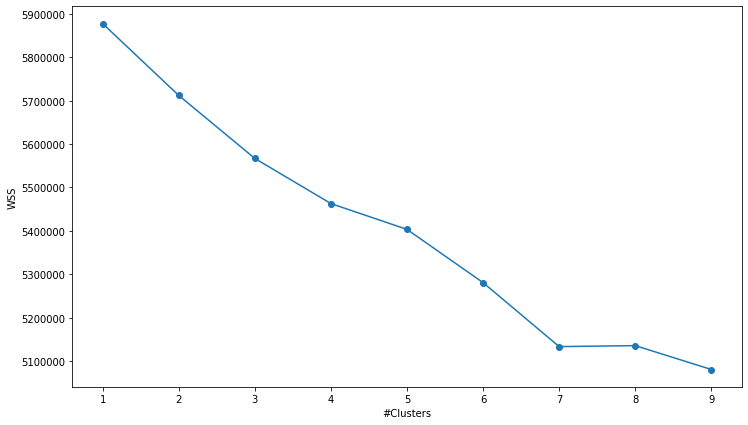

In [61]:
plt.figure(figsize=(12,7))
plt.xlabel('#Clusters')
plt.ylabel('WSS')
plt.plot(clusters_df.num_clusters, clusters_df.cluster_wss,marker='o')
plt.show()

In [63]:
#Building KMeans Cluster Model
kcluster = KMeans(n_clusters = 7, random_state = 1)
kcluster.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [64]:
df['clusters_kmeans'] = kcluster.fit_predict(scaled_df)  #can use only .predict if u have fitted the data alrdy
df

,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,readmitted,total_patient_interaction,numchange,race_AfricanAmerican,race_Caucasian,race_Other,age_0-40,age_41-70,age_71-100,diag_1_Blood,diag_1_Circulatory,diag_1_CongenitalAnomalies,diag_1_Digestive,"diag_1_Endocrine,Nutritional,Metabolic&Immunity",diag_1_ExternalCausesInjury&Poisoning,diag_1_Genitourinary,diag_1_Ill-definedConditions,diag_1_Infectious&Parasitic,diag_1_Injury&Poisoning,diag_1_Mental,diag_1_Musculoskeletal,diag_1_Neoplasms,diag_1_Nervous,diag_1_Pregnancy,diag_1_Respiratory,diag_1_Skin,diag_1_SupplementaryFactors,diag_2_Blood,diag_2_Circulatory,diag_2_CongenitalAnomalies,diag_2_Digestive,"diag_2_Endocrine,Nutritional,Metabolic&Immunity",diag_2_ExternalCausesInjury&Poisoning,diag_2_Genitourinary,diag_2_Ill-definedConditions,diag_2_Infectious&Parasitic,diag_2_Injury&Poisoning,diag_2_Mental,diag_2_Musculoskeletal,diag_2_Neoplasms,diag_2_Nervous,diag_2_Pregnancy,diag_2_Respiratory,diag_2_Skin,diag_2_SupplementaryFactors,diag_3_Blood,diag_3_Circulatory,diag_3_CongenitalAnomalies,diag_3_Digestive,"diag_3_Endocrine,Nutritional,Metabolic&Immunity",diag_3_ExternalCausesInjury&Poisoning,diag_3_Genitourinary,diag_3_Ill-definedConditions,diag_3_Infectious&Parasitic,diag_3_Injury&Poisoning,diag_3_Mental,diag_3_Musculoskeletal,diag_3_Neoplasms,diag_3_Nervous,diag_3_Pregnancy,diag_3_Respiratory,diag_3_Skin,diag_3_SupplementaryFactors,max_glu_serum_abnormal,max_glu_serum_normal,max_glu_serum_not_tested,A1Cresult_abnormal,A1Cresult_normal,A1Cresult_not tested,discharge_disposition_id_discharged_home,discharge_disposition_id_inpatient,discharge_disposition_id_left_AMA,discharge_disposition_id_na,discharge_disposition_id_transferred,discharge_disposition_id_under_treatment,admission_type_id_elective,admission_type_id_emergency,admission_type_id_na,change_Yes,diabetesMed_Yes,clusters_kmeans
0,1,41,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,6
1,3,59,18,9,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,6
2,2,11,13,6,0,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,6
3,2,44,16,7,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,6
4,1,51,8,5,0,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69964,9,50,33,9,0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,2
69965,14,73,26,9,0,1,2,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,3
69966,2,46,17,9,0,3,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,6
69967,5,76,22,9,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,5


In [223]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(scaled_df)
## Getting a visual plot
## Defining Colours and Lables for the plot
def color_fun(row):
    if(row['clusters_kmeans'] == 0):
        return "red"
    if(row['clusters_kmeans'] == 1):
        return "green"
    if(row['clusters_kmeans'] == 2):
        return "blue"
    return 0

df['color'] = df.apply(lambda row: color_fun(row), axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

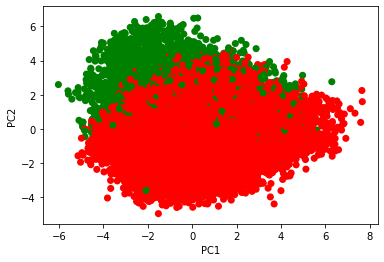

In [224]:
plt.scatter(x = plot_columns[:,0],
            y = plot_columns[:,1], 
            c = df['color'].values.tolist(),
            s = 50, edgecolors = 'none')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [225]:
#Building KMeans Cluster Model
kcluster = KMeans(n_clusters = 3, random_state = 1)
kcluster.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [226]:
df['clusters_kmeans'] = kcluster.fit_predict(scaled_df)  #can use only .predict if u have fitted the data alrdy
df

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,change,diabetesMed,readmitted,total_patient_interaction,numchange,race_1,race_2,age_1,age_2,diag_1_Congenital Anomalies,diag_1_Diseases of Blood and Blood Forming Organs,diag_1_Diseases of Nervous System and Sense Organs,diag_1_Diseases of circulatory system,diag_1_Diseases of respiratory system,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_1_Infectious and Parasitic Disease,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_1_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions",diag_2_Congenital Anomalies,diag_2_Diseases of Blood and Blood Forming Organs,diag_2_Diseases of Nervous System and Sense Organs,diag_2_Diseases of circulatory system,diag_2_Diseases of respiratory system,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_2_Infectious and Parasitic Disease,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_2_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions",diag_3_Congenital Anomalies,diag_3_Diseases of Blood and Blood Forming Organs,diag_3_Diseases of Nervous System and Sense Organs,diag_3_Diseases of circulatory system,diag_3_Diseases of respiratory system,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Skin and Subcutaneous Tissue,"diag_3_Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders",diag_3_Infectious and Parasitic Disease,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Neoplasms,diag_3_Supplementary Classification Of External Causes Of Injury And Poisoning,diag_3_Supplementary Factors Influencing Health Status and Contact with Health Services,"diag_3_Symptoms, Signs and Ill-defined Conditions",max_glu_serum_0,max_glu_serum_1,A1Cresult_0,A1Cresult_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,clusters_kmeans,color
0,0,1,41,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,green
1,0,

In [67]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(scaled_df)
## Getting a visual plot
## Defining Colours and Lables for the plot
def color_fun(row):
    if(row['clusters_kmeans'] == 0):
        return "red"
    if(row['clusters_kmeans'] == 1):
        return "green"
    if(row['clusters_kmeans'] == 2):
        return "blue"
    if(row['clusters_kmeans'] == 3):
        return "black"
    if(row['clusters_kmeans'] == 4):
        return "yellow"
    if(row['clusters_kmeans'] == 5):
        return "purple"
    if(row['clusters_kmeans'] == 6):
        return "orange"
    return 0

df['color'] = df.apply(lambda row: color_fun(row), axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

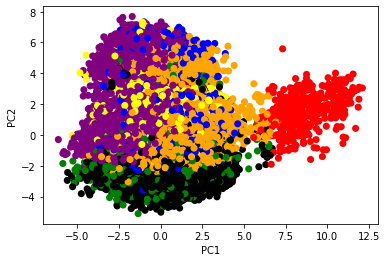

In [68]:
plt.scatter(x = plot_columns[:,0],
            y = plot_columns[:,1], 
            c = df['color'].values.tolist(),
            s = 50, edgecolors = 'none')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()